# ERC Risk Premia Portfolio Backtest

In this notebook we backtest a more advanced risk parity long-only portfolio of ETFs.

Review the basic riskpremia notebook in this directory first.

In [196]:
import os
import sys
import importlib
from itertools import repeat
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import ffn

%matplotlib inline

In [197]:
# Ensure the notebook can find local modules by appending the parent directory to the system path
# Requires a 'donotdelete.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

# Import local modules with hot reload
import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola

In [198]:
tickers = ['VTI', 'TLT', 'GLD']
ticker_n = len(tickers)
price_df = pdr.get_data_yahoo(tickers, start='2000-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,41.046677,50.798897,44.380001
2004-11-19,40.548492,50.393562,44.779999
2004-11-22,40.815372,50.656174,44.950001
2004-11-23,40.829613,50.719013,44.750000
2004-11-24,41.064465,50.719013,45.049999
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


## ERC Weights

Define weights based on the rolling co-variance and the equal risk contribution (ERC) algorithm.

In [199]:
# Sensible EWMA alphas
ewma_vol_alpha = 1.-0.94
ewma_cov_alpha = 1.-0.975

# Calc required time series
ret_df = np.log(price_df/price_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)
cov_df = ret_df.ewm(alpha=ewma_cov_alpha, adjust=False).cov().dropna()
cov_mat = cov_df.groupby('Date').apply(lambda x: x.values)

In [200]:
# Function to calculate ERC weights for each period
def calc_erc_weight(initial_weights, cov_mat, b):
    n = len(initial_weights)
    try:
        w = ffn.core._erc_weights_ccd(initial_weights, cov=cov_mat, b=b, maximum_iterations=1000, tolerance=1e-8)
    except ValueError:
        w = np.full(n, np.NaN)
    return w

In [201]:
# Define our risk budget as equal risk
risk_budget = np.full(ticker_n, 1/ticker_n)

# Get ERC weights
weight_df = ret_df[:-1].copy()
weight_df[:] = [calc_erc_weight(x, y, z) for x, y, z in zip(
    weight_df.shift(1).values, cov_mat, repeat(risk_budget))]
weight_df = weight_df.dropna()
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-22,0.182852,0.269389,0.547760
2004-11-23,0.140533,0.286703,0.572764
2004-11-24,0.141148,0.286215,0.572637
2004-11-26,0.185782,0.250541,0.563677
2004-11-29,0.215504,0.298873,0.485623
...,...,...,...
2022-09-30,0.277624,0.316092,0.406284
2022-10-03,0.268306,0.329628,0.402066
2022-10-04,0.269468,0.329009,0.401523


In [202]:
price_df = price_df.align(weight_df, axis=0, join='inner')[0]

display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-22,40.815372,50.656174,44.950001
2004-11-23,40.829613,50.719013,44.750000
2004-11-24,41.064465,50.719013,45.049999
2004-11-26,41.064465,50.387840,45.290001
2004-11-29,40.975521,49.851120,45.400002
...,...,...,...
2022-09-30,179.470001,102.206001,154.669998
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997


In [203]:
def fixed_min_commission(trade_price, trade_size):
    return 1

result_df = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result_df)

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2004-11-22 VTI       40.815372         0.000000      0.000000        0.000000   
           TLT       50.656174         0.000000      0.000000        0.000000   
           GLD       44.950001         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2004-11-23 VTI       40.829613        44.799696   1829.154231        0.183344   
...                        ...              ...           ...             ...   
2022-10-05 cash       1.000000       581.741947    581.741947        0.014873   
2022-10-06 VTI      187.770004        54.810538  10291.774895        0.264381   
           TLT      101.980003       119.287131  12164.902029        0.312499   
           GLD      159.630005        99.538926  15889.399168        0.408176   
           cash       1.000000       581.741947    581.741947        0.014944   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2004-11-22 VTI           0.182852      0.182852      True           0.182852   
           TLT           0.269389      0.269389      True           0.269389   
           GLD           0.547760      0.547760      True           0.547760   
           cash          0.000000     -1.000000     False           1.000000   
2004-11-23 VTI           0.140533     -0.042812      True           0.140533   
...                           ...           ...       ...                ...   
2022-10-05 cash          0.000000     -0.014873     False           0.014873   
2022-10-06 VTI           0.262572     -0.001809     False           0.264381   
           TLT           0.333912      0.021413     False           0.312499   
           GLD           0.403516     -0.004660     False           0.408176   
           cash          0.000000     -0.014944     False           0.014944   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2004-11-22 VTI              0.182852  1828.516271   44.799696         1.0   
           TLT              0.269389  2693.886520   53.179826         1.0   
           GLD              0.547760  5477.597208  121.859780         1.0   
           cash             0.000000     0.000000    0.000000         0.0   
2004-11-23 VTI             -0.042812  -427.116208  -10.460942         1.0   
...                              ...          ...         ...         ...   
2022-10-05 cash             0.000000     0.000000    0.000000         0.0   
2022-10-06 VTI              0.000000     0.000000    0.000000         0.0   
           TLT              0.000000     0.000000    0.000000         0.0   
           GLD              0.000000     0.000000    0.000000         0.0   
           cash             0.000000     0.000000    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2004-11-22 VTI          44.799696  
           TLT          53.179826  
           GLD         121.859780  
           cash         -3.000000  
2004-11-23 VTI          34.338754  
...                           ...  
2022-10-05 cash        581.741947  
2022-10-06 VTI          54.810538  
           TLT         119.287131  
           GLD          99.538926  
           cash        581.741947  

[18000 rows x 13 columns]

In [204]:
trades_df = result_df.loc[result_df['do_trade'] == True]
display(len(trades_df))
display(trades_df.tail(5))

286

,,price,start_portfolio,equity,current_weight,target_weight,delta_weight,do_trade,adj_target_weight,adj_delta_weight,trade_value,trade_size,commission,end_portfolio
datetime,Symbols,,,,,,,,,,,,,
2022-03-08,GLD,191.509995,101.593600,19456.189824,0.418002,0.364311,-0.053691,True,0.364311,-0.053691,-2499.082537,-13.049358,1.0,88.544242
2022-04-04,GLD,180.369995,88.544242,15970.724485,0.343485,0.386136,0.042651,True,0.386136,0.042651,1983.111026,10.994684,1.0,99.538926
2022-04-21,VTI,218.415970,73.898867,16140.692787,0.359989,0.315127,-0.044862,True,0.315127,-0.044862,-2011.474695,-9.209376,1.0,64.689492
2022-05-04,VTI,213.804062,64.689492,13830.876110,0.316343,0.268033,-0.048310,True,0.268033,-0.048310,-2112.160519,-9.878954,1.0,54.810538
2022-05-06,TLT,112.531410,101.261977,11395.153035,0.267096,0.314640,0.047544,True,0.314640,0.047544,2028.396048,18.025154,1.0,119.287131


In [205]:
stat_df = calc_stats(result_df.copy())
display(stat_df)

,start,end,rf,total_return,cagr,max_drawdown,calmar,mtd,three_month,six_month,...,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc,initial,final,profit
equity,2004-11-22,2022-10-06,0.0,2.892782,0.079023,-0.21346,0.370203,0.024251,-0.045572,-0.146036,...,-0.18307,-0.012525,23.604938,0.021188,-0.016444,0.833333,0.853659,10000.0,38927.818039,28927.818039


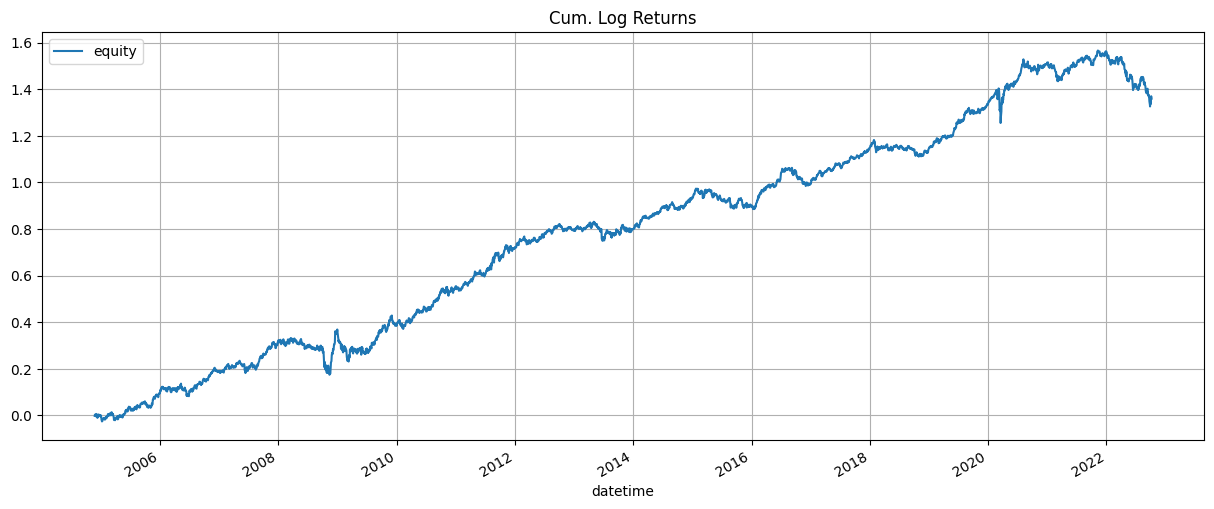

In [206]:
ax = calc_log_returns(result_df).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

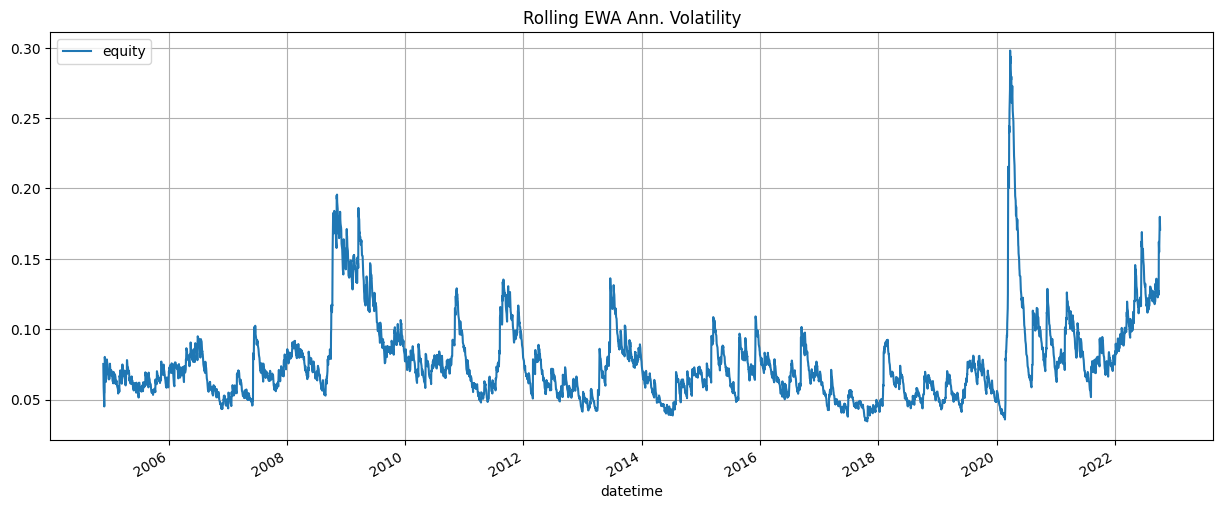

In [207]:
ax = calc_rolling_ann_vola(result_df).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()